<a href="https://colab.research.google.com/github/caonhatlinhth/time-series-projects-practice/blob/main/time_series_passengers_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
passenger_csv = '/content/drive/My Drive/Colab Notebooks/Time Series/Data/air_passenger.csv'

In [ ]:
with open(passenger_csv, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

,Date,#Passengers

First data point looks like this:

0,1949-01-01,112

Second data point looks like this:

1,1949-02-01,118



In [ ]:
def plot_series(time, series, format="-", start = 0 , end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

**Parsing the data**

In [ ]:
def parse_data_from_file(filename):

    times = []
    passengers = []

    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            passengers.append(float(row[2]))
        times = [x for x in range(0, len(passengers))]

    return times, passengers

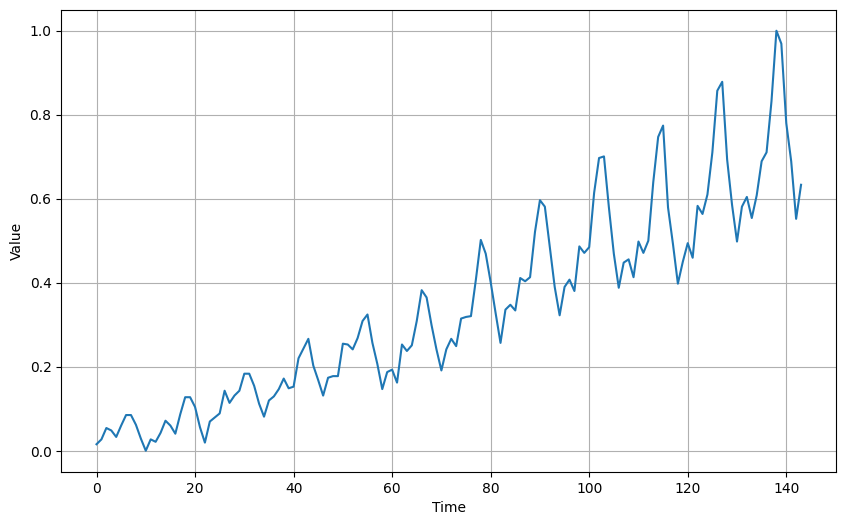

In [ ]:
from sklearn.preprocessing import MinMaxScaler

@dataclass
class G:
    TEMPERATURES_CSV = '/content/drive/My Drive/Colab Notebooks/Time Series/Data/air_passenger.csv'
    times, passengers = parse_data_from_file(passenger_csv)
    TIME = np.array(times)
    SERIES = np.array(passengers)
    SPLIT_TIME = 120
    WINDOW_SIZE = 10
    BATCH_SIZE = 10
    SHUFFLE_BUFFER_SIZE = 30

scaler = MinMaxScaler()
G.SERIES = scaler.fit_transform(G.SERIES.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Processing the data**

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

**Define model architecture**

In [ ]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    return model

**Adjust learning rate**

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-8)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
11/11 [==============================] - 7s 12ms/step - loss: 0.0509 - mae: 0.2603 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0104 - mae: 0.1224 - lr: 1.1220e-04
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0136 - mae: 0.1279 - lr: 1.2589e-04
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0089 - mae: 0.1079 - lr: 1.4125e-04
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0141 - mae: 0.1422 - lr: 1.5849e-04
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0056 - mae: 0.0809 - lr: 1.7783e-04
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0048 - mae: 0.0756 - lr: 1.9953e-04
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0048 - mae: 0.0787 - lr: 2.2387e-04
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - mae: 0.0775 - lr: 2.5119e-

In [ ]:
print(lr_history.history["lr"])
print(lr_history.history["loss"])

[1e-04, 0.000112201844, 0.00012589255, 0.00014125375, 0.00015848932, 0.00017782794, 0.00019952623, 0.00022387212, 0.00025118864, 0.0002818383, 0.00031622776, 0.00035481338, 0.00039810716, 0.00044668358, 0.0005011872, 0.0005623413, 0.00063095737, 0.0007079458, 0.0007943282, 0.00089125097, 0.001, 0.0011220184, 0.0012589254, 0.0014125375, 0.0015848932, 0.0017782794, 0.0019952622, 0.0022387211, 0.0025118864, 0.002818383, 0.0031622776, 0.003548134, 0.0039810715, 0.004466836, 0.0050118724, 0.0056234132, 0.0063095735, 0.007079458, 0.007943282, 0.008912509, 0.01, 0.011220184, 0.012589254, 0.014125375, 0.015848933, 0.017782794, 0.019952623, 0.022387212, 0.025118865, 0.028183829, 0.031622775, 0.035481337, 0.039810717, 0.044668358, 0.050118722, 0.056234132, 0.06309573, 0.070794575, 0.07943282, 0.0891251, 0.1, 0.11220185, 0.12589253, 0.14125375, 0.15848932, 0.17782794, 0.19952624, 0.22387211, 0.25118864, 0.2818383, 0.31622776, 0.3548134, 0.39810717, 0.4466836, 0.5011872, 0.56234133, 0.63095737, 0.

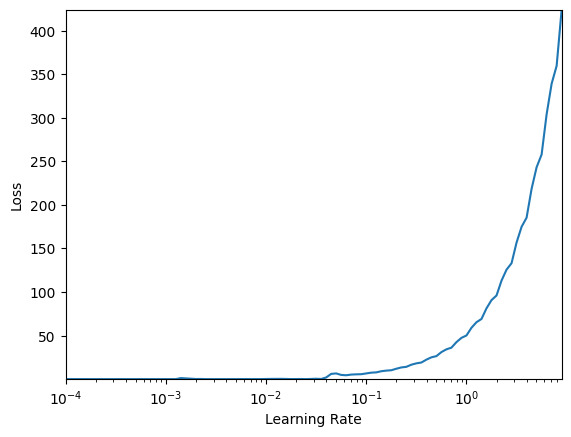

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([min(lr_history.history["lr"]), max(lr_history.history["lr"]), min(lr_history.history["loss"]), max(lr_history.history["loss"])])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

**Compiling the model**

In [ ]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])

    return model

In [ ]:
model = create_model()
history = model.fit(train_set, epochs=50)

Epoch 1/50
11/11 [==============================] - 7s 12ms/step - loss: 0.3395 - mae: 0.6429
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0167 - mae: 0.1423
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0169 - mae: 0.1468
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0083 - mae: 0.1000
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0047 - mae: 0.0748
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0070 - mae: 0.0946
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0147 - mae: 0.1358
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0232 - mae: 0.1713
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0211 - mae: 0.1766
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.1182
Epoch 11/50
11/11 [==============================] - 0s 9ms/step 

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

**Faster model forecast**

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

5/5 [==============================] - 3s 30ms/step


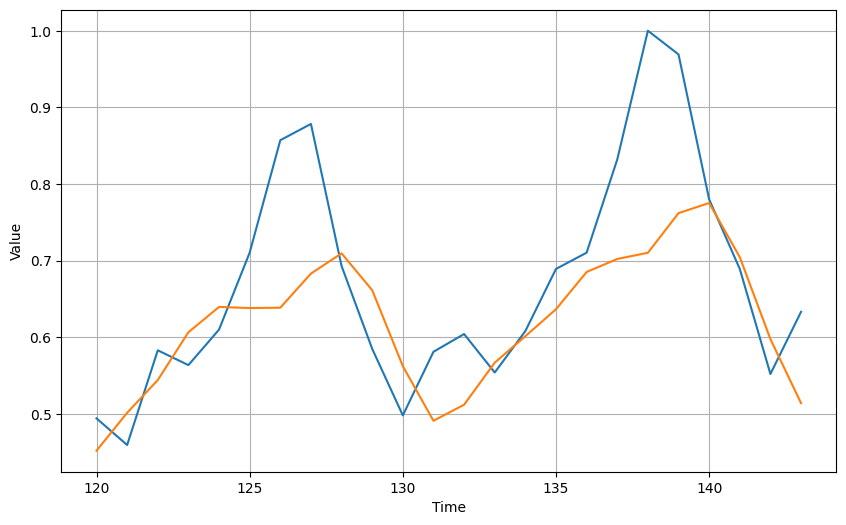

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.01, mae: 0.08 for forecast
